In [ ]:
#load libraries
import pandas as pd
import numpy as np
from PIL import Image
from keras.applications.resnet_v2 import ResNet152V2, preprocess_input
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Flatten, Input, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping

2024-03-07 08:23:37.408563: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
#load csv data
csv_file = "/media/kanjibrian/Transcend7/concat/concatenated_file.csv"
df_csv = pd.read_csv(csv_file)

In [ ]:
#define a function to load and preprocess the image
def load_and_preprocess_images(image_ids, image_folder):
    images = []
    for image_id in image_ids:
        image_path = f"{image_folder}/{image_id}"  # Change the extension if images are not in JPG format
        img = Image.open(image_path)
        img = img.resize((224, 224))
        img = np.array(img)
        #remove extra channels
        if img.shape[2] > 3:
            img=img[:,:,:3]
        img = img.astype('float32') / 255.0  # Normalize between 0 and 1
        img = preprocess_input(img)  # Preprocess for VGG16
        images.append(img)
    return np.array(images)

# Load and preprocess images
image_folder = "/media/kanjibrian/Transcend7/testing"
image_ids = df_csv['image_id'].values
image_data = load_and_preprocess_images(image_ids, image_folder)

In [ ]:
#convert string labels to numerical labels
label_encoder=LabelEncoder()
df_csv['Label']=label_encoder.fit_transform(df_csv['Label'])

In [ ]:
len(label_encoder.classes_)

3

In [ ]:
#split data into features (X) and labels (y)
X_images=image_data
X_features=df_csv[['Temperature','Humidity']].values
y=to_categorical(df_csv['Label'])

In [ ]:
#slit data into training and validation sets
X_train_img, X_val_img, X_train_feat, X_val_feat, y_train, y_val = train_test_split(X_images, X_features, y, test_size=0.2, random_state=42)

In [ ]:
#load efficientnetB4 model
base_model=ResNet152V2(weights='imagenet', include_top= False, input_shape=(224,224,3))
#freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable=False
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)

# Create an input layer for the features
input_features = Input(shape=(2,))
x_feat = Dense(128, activation='relu')(input_features)
x_feat= Dense(64, activation='relu')(x_feat)

# Concatenate image features and CSV features
concatenated=concatenate([x, x_feat])

# Final output layer
predictions = Dense(len(label_encoder.classes_), activation='softmax')(concatenated)

# Create the final model
model = Model(inputs=[base_model.input, input_features], outputs=predictions)

2024-03-07 08:25:09.263145: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-07 08:25:09.264779: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


234545216/234545216 [==============================] - 15s 0us/step


In [ ]:
#compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss',patience=10, verbose=1, restore_best_weights=True)

history = model.fit(
    [X_train_img, X_train_feat], y_train,
    epochs=50,
    batch_size=32,
    validation_data=([X_val_img, X_val_feat], y_val),
    callbacks=[early_stopping])

Epoch 1/50
66/66 [==============================] - 2749s 42s/step - loss: 1.1395 - accuracy: 0.8049 - val_loss: 0.1327 - val_accuracy: 0.9525
Epoch 2/50
66/66 [==============================] - 2571s 39s/step - loss: 0.1786 - accuracy: 0.9310 - val_loss: 0.1610 - val_accuracy: 0.9354
Epoch 3/50
66/66 [==============================] - 2506s 38s/step - loss: 0.1238 - accuracy: 0.9486 - val_loss: 0.0990 - val_accuracy: 0.9639
Epoch 4/50
66/66 [==============================] - 2568s 39s/step - loss: 0.1330 - accuracy: 0.9472 - val_loss: 0.0734 - val_accuracy: 0.9810
Epoch 5/50
66/66 [==============================] - 2506s 38s/step - loss: 0.0813 - accuracy: 0.9719 - val_loss: 0.0683 - val_accuracy: 0.9810
Epoch 6/50
66/66 [==============================] - 2506s 38s/step - loss: 0.0594 - accuracy: 0.9805 - val_loss: 0.0505 - val_accuracy: 0.9829
Epoch 7/50
66/66 [==============================] - 2552s 39s/step - loss: 0.0528 - accuracy: 0.9848 - val_loss: 0.0735 - val_accuracy: 0.9772

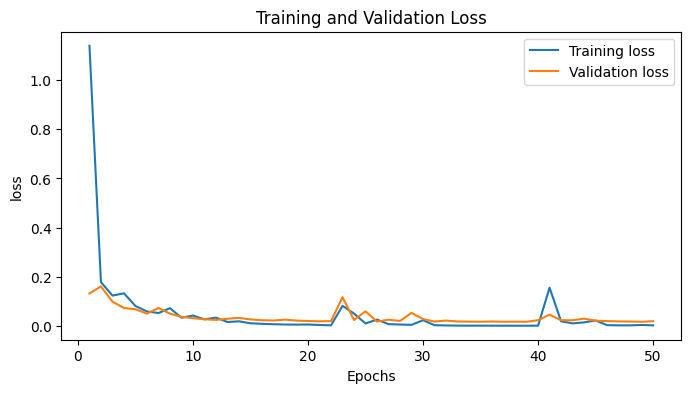

In [ ]:
#plotting the training and validation loss
import matplotlib.pyplot as plt

#extracting loss and validation loss from the history object
train_loss=history.history['loss']
val_loss=history.history['val_loss']

#create a range for the number of epochs
epochs=range(1,len(train_loss)+1)
#plotting training and validation loss
plt.figure(figsize=(8,4))
plt.plot(epochs, train_loss,label='Training loss')
plt.plot(epochs,val_loss,label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
#Evaluating the model
loss, accuracy = model.evaluate([X_val_img, X_val_feat], y_val)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")

17/17 [==============================] - 561s 33s/step - loss: 0.0195 - accuracy: 0.9943
Validation Loss: 0.019540702924132347, Validation Accuracy: 0.9942965507507324


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix